In [ ]:
!pip install tensorflow==2.1

In [2]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [3]:
from google.colab import files
uploaded = files.upload()

Saving jena_climate_2009_2016.csv to jena_climate_2009_2016.csv


In [4]:
!ls

jena_climate_2009_2016.csv  sample_data


In [5]:
import os


fname = os.path.join('jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [6]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

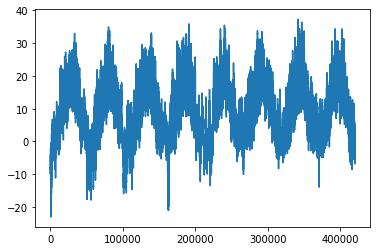

In [7]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

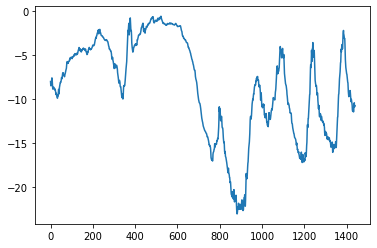

In [8]:
plt.plot(range(1440), temp[:1440])
plt.show()

In [9]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [10]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [11]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [12]:
# np.mean(np.abs(preds - targets))

In [13]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 500 steps, validate for 769 steps
Epoch 1/20
500/500 [==============================] - 17s 33ms/step - loss: 1.3474 - val_loss: 0.6963
Epoch 2/20
500/500 [==============================] - 15s 30ms/step - loss: 0.4732 - val_loss: 0.3815
Epoch 3/20
500/500 [==============================] - 14s 29ms/step - loss: 0.3046 - val_loss: 0.3175
Epoch 4/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2700 - val_loss: 0.3300
Epoch 5/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2541 - val_loss: 0.3183
Epoch 6/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2461 - val_loss: 0.3129
Epoch 7/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2386 - val_loss: 0.3232
Epoch 8/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2324 - val_loss: 0.3251
Epoch 9/20
500

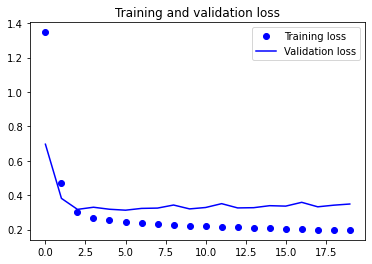

In [15]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 500 steps, validate for 769 steps
Epoch 1/20
500/500 [==============================] - 39s 78ms/step - loss: 0.3040 - val_loss: 0.2726
Epoch 2/20
500/500 [==============================] - 33s 66ms/step - loss: 0.2866 - val_loss: 0.2694
Epoch 3/20
500/500 [==============================] - 33s 67ms/step - loss: 0.2779 - val_loss: 0.2717
Epoch 4/20
500/500 [==============================] - 33s 66ms/step - loss: 0.2725 - val_loss: 0.2645
Epoch 5/20
500/500 [==============================] - 33s 65ms/step - loss: 0.2684 - val_loss: 0.2647
Epoch 6/20
500/500 [==============================] - 33s 66ms/step - loss: 0.2639 - val_loss: 0.2662
Epoch 7/20
500/500 [==============================] - 33s 66ms/step - loss: 0.2599 - val_loss: 0.2673
Epoch 8/20
500/500 [==============================] - 33s 66ms/step - loss: 0.2550 - val_loss: 0.2696
Epoch 9/20
500/500 [==============================] - 33s 66ms/step - loss: 0.2486 - val_l

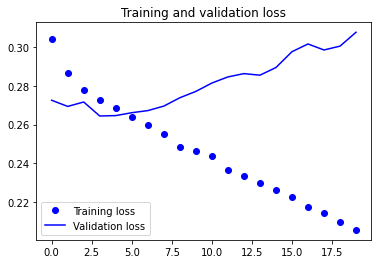

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 500 steps, validate for 769 steps
Epoch 1/40
500/500 [==============================] - 280s 560ms/step - loss: 0.3370 - val_loss: 0.2748
Epoch 2/40
500/500 [==============================] - 277s 555ms/step - loss: 0.3110 - val_loss: 0.2746
Epoch 3/40
500/500 [==============================] - 279s 559ms/step - loss: 0.3053 - val_loss: 0.2685
Epoch 4/40
500/500 [==============================] - 278s 555ms/step - loss: 0.2997 - val_loss: 0.2695
Epoch 5/40
500/500 [==============================] - 276s 552ms/step - loss: 0.2973 - val_loss: 0.2674
Epoch 6/40
500/500 [==============================] - 275s 550ms/step - loss: 0.2938 - val_loss: 0.2666
Epoch 7/40
500/500 [==============================] - 276s 552ms/step - loss: 0.2924 - val_loss: 0.2651
Epoch 8/40
500/500 [==============================] - 278s 556ms/step - loss: 0.2911 - val_loss: 0.2778
Epoch 9/40
500/500 [==============================] - 276s 553ms/step - lo

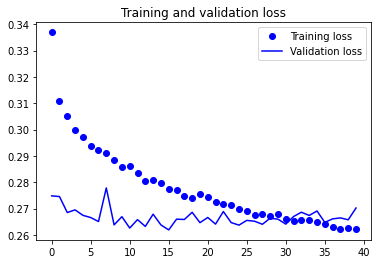

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [21]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 500 steps, validate for 769 steps
Epoch 1/20
500/500 [==============================] - 35s 69ms/step - loss: 0.4808 - val_loss: 0.4816
Epoch 2/20
500/500 [==============================] - 33s 65ms/step - loss: 0.4515 - val_loss: 0.4749
Epoch 3/20
500/500 [==============================] - 33s 66ms/step - loss: 0.4059 - val_loss: 0.4555
Epoch 4/20
500/500 [==============================] - 33s 66ms/step - loss: 0.3617 - val_loss: 0.4256
Epoch 5/20
500/500 [==============================] - 33s 66ms/step - loss: 0.3382 - val_loss: 0.4411
Epoch 6/20
500/500 [==============================] - 33s 66ms/step - loss: 0.3209 - val_loss: 0.4385
Epoch 7/20
500/500 [==============================] - 33s 66ms/step - loss: 0.3058 - val_loss: 0.4270
Epoch 8/20
500/500 [==============================] - 33s 66ms/step - loss: 0.2889 - val_loss: 0.4058
Epoch 9/20
500/500 [==============================] - 33s 66ms/step - loss: 0.2805 - val_l

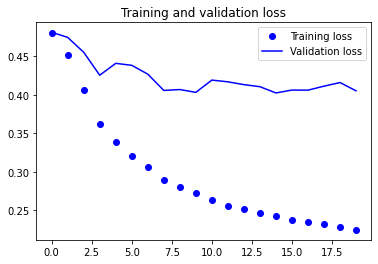

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [23]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words (among top max_features most common words)
maxlen = 500

# Load data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Reverse sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

17465344/17464789 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/keras/datasets/imdb.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/keras/datasets/imdb.py:130: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 21s 1ms/sample - loss: 0.4988 - acc: 0.7571 - val_loss: 0.3916 - val_acc: 0.8440
Epoch 2/10
20000/20000 [==============================] - 17s 874us/sample - loss: 0.3139 - acc: 0.8791 - val_loss: 0.3480 - val_acc: 0.8550
Epoch 3/10
20000/20000 [==============================] - 17s 873us/sample - loss: 0.2905 - acc: 0.8985 - val_loss: 0.3106 - val_acc: 0.8808
Epoch 4/10
20000/20000 [==============================] - 17s 874us/sample - loss: 0.2242 - acc: 0.9204 - val_loss: 0.3486 - val_acc: 0.8530
Epoch 5/10
20000/20000 [==============================] - 18s 876us/sample - loss: 0.2043 - acc: 0.9301 - val_loss: 0.3868 - val_acc: 0.8424
Epoch 6/10
20000/20000 [==============================] - 17s 870us/sample - loss: 0.1791 - acc: 0.9390 - val_loss: 0.8666 - val_acc: 0.7912
Epoch 7/10
20000/20000 [==============================] - 18s 899us/sample - loss: 0.1660 - acc: 0.9420 - v

In [24]:
from tensorflow.keras import backend as K
K.clear_session()

In [25]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 34s 2ms/sample - loss: 0.5909 - acc: 0.6981 - val_loss: 0.3961 - val_acc: 0.8562
Epoch 2/10
20000/20000 [==============================] - 30s 2ms/sample - loss: 0.3680 - acc: 0.8587 - val_loss: 0.5130 - val_acc: 0.8160
Epoch 3/10
20000/20000 [==============================] - 30s 2ms/sample - loss: 0.2788 - acc: 0.8972 - val_loss: 0.3141 - val_acc: 0.8726
Epoch 4/10
20000/20000 [==============================] - 30s 2ms/sample - loss: 0.2373 - acc: 0.9157 - val_loss: 0.4851 - val_acc: 0.7914
Epoch 5/10
20000/20000 [==============================] - 31s 2ms/sample - loss: 0.2082 - acc: 0.9261 - val_loss: 0.3070 - val_acc: 0.8816
Epoch 6/10
20000/20000 [==============================] - 31s 2ms/sample - loss: 0.1782 - acc: 0.9404 - val_loss: 0.3338 - val_acc: 0.8662
Epoch 7/10
20000/20000 [==============================] - 31s 2ms/sample - loss: 0.1690 - acc: 0.9430 - val_loss: 0.3

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 500 steps, validate for 769 steps
Epoch 1/40
500/500 [==============================] - 71s 142ms/step - loss: 0.2927 - val_loss: 0.2707
Epoch 2/40
500/500 [==============================] - 68s 136ms/step - loss: 0.2759 - val_loss: 0.2636
Epoch 3/40
500/500 [==============================] - 68s 136ms/step - loss: 0.2701 - val_loss: 0.2630
Epoch 4/40
500/500 [==============================] - 68s 136ms/step - loss: 0.2639 - val_loss: 0.2651
Epoch 5/40
500/500 [==============================] - 68s 136ms/step - loss: 0.2577 - val_loss: 0.2654
Epoch 6/40
500/500 [==============================] - 68s 136ms/step - loss: 0.2538 - val_loss: 0.2639
Epoch 7/40
500/500 [==============================] - 68s 136ms/step - loss: 0.2473 - val_loss: 0.2639
Epoch 8/40
500/500 [==============================] - 68s 136ms/step - loss: 0.2404 - val_loss: 0.2690
Epoch 9/40
500/500 [==============================] - 68s 137ms/step - loss: 0.235